<a href="https://colab.research.google.com/github/DanishFaraaz/Deep-Learning-Projects/blob/main/21_Keras_Transfer_Learning_and_Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

**Example: Setting a trainable layer to False**

In [ ]:
layer1 = keras.layers.Dense(3, activation='relu')
layer2 = keras.layers.Dense(3, activation='sigmoid')
model = keras.Sequential([keras.Input(shape=(3,)), layer1, layer2])

layer1.trainable = False

initial_layer1_weight_values = layer1.get_weights()

model.compile(optimizer='adam', loss='mse')
model.fit(np.random.random((2,3)), np.random.random((2,3)))

1/1 [==============================] - 7s 7s/step - loss: 0.0952


In [ ]:
final_layer1_weight_values = layer1.get_weights()

if initial_layer1_weight_values[0].all() == final_layer1_weight_values[0].all():
  print('Weights unchanged')

if initial_layer1_weight_values[1].all() == final_layer1_weight_values[1].all():
  print('Weights unchanged')

Weights unchanged
Weights unchanged


**Implementing Transfer Learning**

In [ ]:
import tensorflow_datasets as tfds

tfds.disable_progress_bar()

train_ds, validation_ds, test_ds = tfds.load('cats_vs_dogs', split=['train[:40%]', 'train[40%:50%]', 'train[50%:60%]'])

print(f'Number of training samples: {tf.data.experimental.cardinality(train_ds)}')
print(f'Number of validation samples: {tf.data.experimental.cardinality(validation_ds)}')
print(f'Number of test samples: {tf.data.experimental.cardinality(test_ds)}')

Number of training samples: 9305
Number of validation samples: 2326
Number of test samples: 2326


In [ ]:
train_ds.

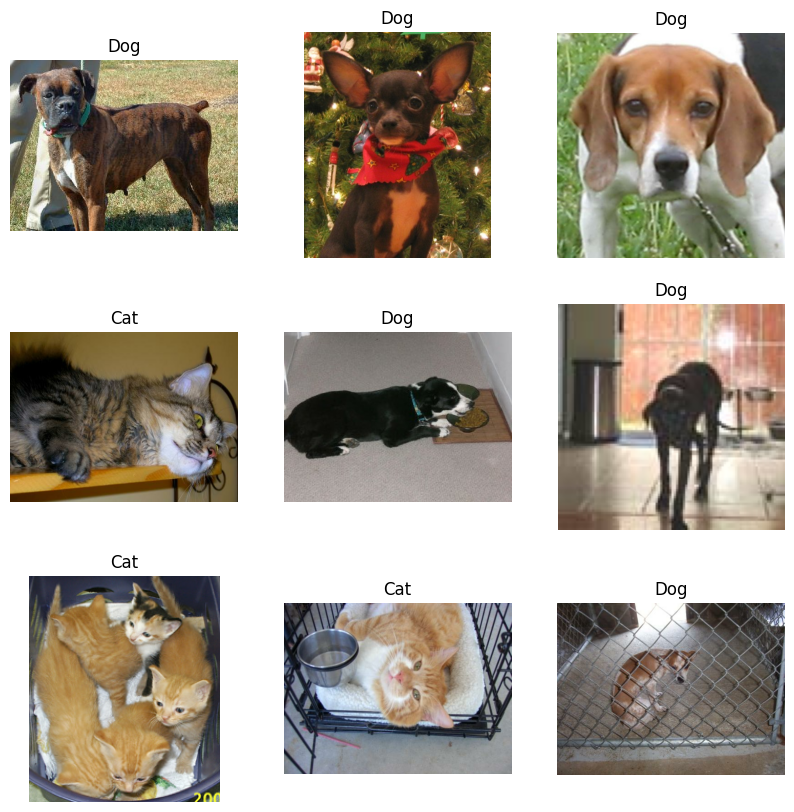

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))

# Visualizing the first 9 training samples
for i, sample in enumerate(train_ds.take(9)):
  image, label = sample['image'], sample['label']
  ax = plt.subplot(3, 3, i+1)
  plt.imshow(image)
  plt.title('Cat' if int(label)==0 else 'Dog')
  plt.axis('off')

**Standardize Data**

In [ ]:
size = (150, 150)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))

In [ ]:
batch_size = 32

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

**Random Data Augemntation**

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip('horizontal'),
        layers.experimental.preprocessing.RandomRotation(0.1)
    ]
)

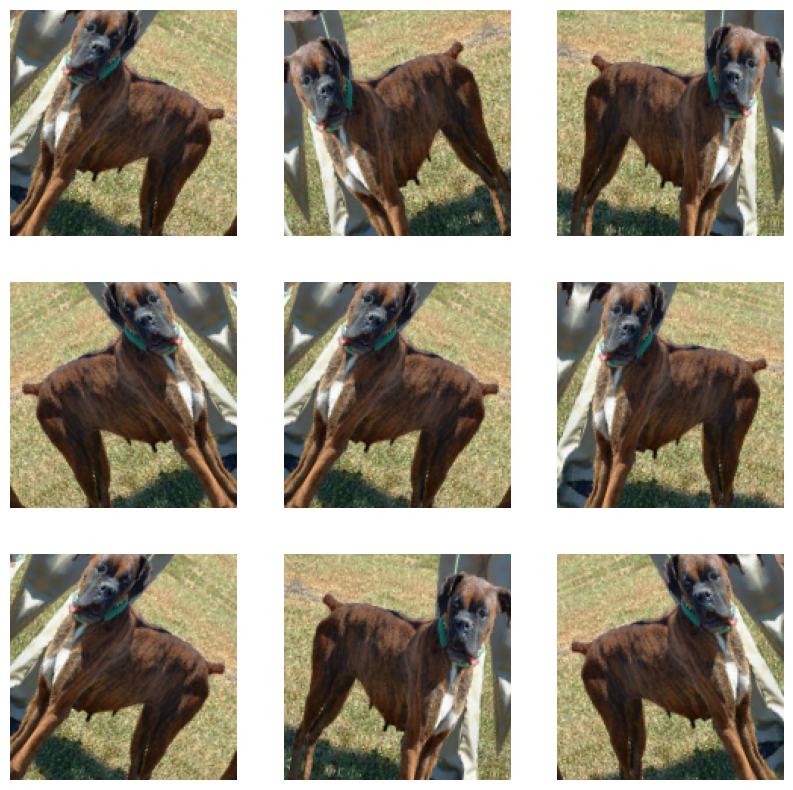

In [ ]:
import numpy as np

for images, labels in train_ds.take(1):
  plt.figure(figsize=(10,10))
  first_image = images[0]
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0), training=True)
    plt.imshow(augmented_image[0].numpy().astype('int32'))
    plt.axis('off')

**Building Our Model**

In [ ]:
base_model = keras.applications.Xception(
    weights='imagenet',
    input_shape=(150,150,3),
    include_top=False
)

base_model.trainable = False

inputs = keras.Input(shape=(150,150,3))
x = data_augmentation(inputs)

scale_layer = keras.layers.Rescaling(scale=1/127.5, offset=-1)
x = scale_layer(x)

x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

83683744/83683744 [==============================] - 5s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 150, 150, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0      

**Training the top layer**

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()]
)

epochs = 20
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

**Fine Tuning**

In [ ]:
base_model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()]
)

epochs = 20
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)